## Нейронные сети: зависимость ошибки и обучающей способности от числа нейронов

В этом задании вы будете настраивать двуслойную нейронную сеть для решения задачи многоклассовой классификации. Предлагается выполнить процедуры загрузки и разбиения входных данных, обучения сети и подсчета ошибки классификации. Предлагается определить оптимальное количество нейронов в скрытом слое сети. Нужно так подобрать число нейронов, чтобы модель была с одной стороны несложной, а с другой стороны давала бы достаточно точный прогноз и не переобучалась. Цель задания -- показать, как зависит точность и обучающая способность сети от ее сложности.

Для решения задачи многоклассовой классификации предлагается воспользоваться библиотекой построения нейронных сетей [pybrain](http://pybrain.org/). Библиотека содержит основные модули инициализации двуслойной нейронной сети прямого распространения, оценки ее параметров с помощью метода обратного распространения ошибки (backpropagation) и подсчета ошибки.

Установить библиотеку pybrain можно с помощью стандартной системы управления пакетами pip:

```
pip install pybrain
```
Кроме того, для установки библиотеки можно использовать и другие способы, приведенные в [документации](https://github.com/pybrain/pybrain/wiki/installation). 

###  Используемые данные

Рассматривается задача оценки качества вина по его физико-химическим свойствам [1]. Данные размещены в [открытом доступе](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в репозитории UCI  и содержат 1599 образцов красного вина, описанных 11 признаками, среди которых -- кислотность, процентное содержание сахара, алкоголя и пр. Кроме того, каждому объекту поставлена в соответствие оценка качества по шкале от 0 до 10. Требуется восстановить оценку качества вина по исходному признаковому описанию.

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.  In Decision Support Systems, Elsevier, 47(4):547-553, 2009. 

In [1]:
# Выполним инициализацию основных используемых модулей
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

Выполним загрузку данных

In [4]:
with open('winequality-red.csv') as f:
    f.readline()  # пропуск заголовочной строки
    data = np.loadtxt(f, delimiter=';')

В качестве альтернативного варианта, можно выполнить загрузку данных напрямую из репозитория UCI, воспользовавшись библиотекой urllib.

In [3]:
import urllib
# URL for the Wine Quality Data Set (UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# загрузка файла
f = urllib.urlopen(url)
f.readline()  # пропуск заголовочной строки
data = np.loadtxt(f, delimiter=';')

IOError: [Errno socket error] [Errno 10061] No connection could be made because the target machine actively refused it

Выделим из данных целевую переменную. Классы в задаче являются несбалинсированными: основной доле объектов поставлена оценка качества от 5 до 7. Приведем задачу к трехклассовой: объектам с оценкой качества меньше пяти поставим оценку 5, а объектам с оценкой качества больше семи поставим 7. 

In [5]:
TRAIN_SIZE = 0.7 # Разделение данных на обучающую и контрольную части в пропорции 70/30%
from sklearn.cross_validation import train_test_split

y = data[:, -1]
np.place(y, y < 5, 5)
np.place(y, y > 7, 7)
y -= min(y)
X = data[:, :-1]
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)

### Двуслойная нейронная сеть

Двуслойная нейронная сеть представляет собой функцию распознавания, которая може быть записана в виде следующей суперпозиции:

$f(x,W)=h^{(2)}\left(\sum\limits_{i=1}^D w_i^{(2)}h^{(1)}\left(\sum\limits_{j=1}^n w_{ji}^{(1)}x_j+b_i^{(1)}\right)+b^{(2)}\right)$, где

$x$ -- исходный объект (сорт вина, описанный 11 признаками), $x_j$ -- соответствующий признак,

$n$ --  количество нейронов во входном слое сети, совпадающее с количеством признаков,

$D$ --  количество нейронов в скрытом слое сети,

$w_i^{(2)}, w_{ji}^{(1)}, b_i^{(1)}, b^{(2)}$ --  параметры сети, соответствующие весам нейронов,

$h^{(1)}, h^{(2)}$ -- функции активации.

В качестве функции активации на скрытом слое сети используется линейная функция. На выходном слое сети используется функция активации softmax, являющаяся обобщением сигмоидной функции на многоклассовый случай:

$y_k=\text{softmax}_k(a_1,...,a_k)=\frac{\exp(a_k)}{\sum_{k=1}^K\exp(a_k)}.$



### Настройка параметров сети

Оптимальные параметры сети $W_{opt}$ определяются путем минимизации функции ошибки:

$W_{opt}=\arg\min\limits_{W}L(W)+\lambda\|W\|^2$.

Здесь $L(W)$ является функцией ошибки многоклассовой классификации,

$L(W)=- \sum^N_{n=1}\sum^K_{k=1} t_{kn} log(y_{kn}),$

$t_{kn}$ -- бинарно закодированные метки классов, $K$ -- количество меток, $N$ -- количество объектов,

а $\lambda\|W\|^2$ является регуляризующим слагаемым, контролирующим суммарный вес параметров сети и предотвращающий эффект переобучения.

Оптимизация параметров выполняется методом обратного распространения ошибки (backpropagation).

Выполним загрузку основных модулей: ClassificationDataSet -- структура данных pybrain, buildNetwork -- инициализация нейронной сети, BackpropTrainer -- оптимизация параметров сети методом backpropagation, SoftmaxLayer -- функция softmax, соответствующая выходному слою сети, percentError -- функцию подсчета ошибки классификации (доля неправильных ответов). 

In [7]:
from pybrain.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError

Инициализируем основные параметры задачи: HIDDEN_NEURONS_NUM -- количество нейронов скрытого слоя, MAX_EPOCHS -- максимальное количество итераций алгоритма оптимизации

In [8]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

Инициализируем структуру данных ClassificationDataSet, используемую библиотекой pybrain. Для инициализации структура принимает два аргумента: количество признаков *np.shape(X)[1]* и количество различных меток классов *len(np.unique(y))*.

Кроме того, произведем бинаризацию целевой переменной с помощью функции *_convertToOneOfMany( )* и разбиение данных на обучающую и контрольную части.

In [9]:
# Конвертация данных в структуру ClassificationDataSet
# Обучающая часть
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
# Первый аргумент -- количество признаков np.shape(X)[1], второй аргумент -- количество меток классов len(np.unique(y_train)))
ds_train.setField('input', X_train) # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis]) # Инициализация ответов; np.newaxis создает вектор-столбец
ds_train._convertToOneOfMany( ) # Бинаризация вектора ответов
# Контрольная часть
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

Инициализируем двуслойную сеть и произведем оптимизацию ее параметров. Аргументами для инициализации являются:

ds.indim -- количество нейронов на входном слое сети, совпадает с количеством признаков (в нашем случае 11),

HIDDEN_NEURONS_NUM -- количество нейронов в скрытом слое сети,

ds.outdim -- количество нейронов на выходном слое сети, совпадает с количеством различных меток классов (в нашем случае 3),

SoftmaxLayer -- функция softmax, используемая на выходном слое для решения задачи многоклассовой классификации.

In [10]:
np.random.seed(0) # Зафиксируем seed для получения воспроизводимого результата

# Построение сети прямого распространения (Feedforward network)
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)
# ds.indim -- количество нейронов входного слоя, равне количеству признаков
# ds.outdim -- количество нейронов выходного слоя, равное количеству меток классов
# SoftmaxLayer -- функция активации, пригодная для решения задачи многоклассовой классификации

init_params = np.random.random((len(net.params))) # Инициализируем веса сети для получения воспроизводимого результата
net._setParameters(init_params)

In [11]:
len(net.params)

1503

 Выполним оптимизацию параметров сети. График ниже показывает сходимость функции ошибки на обучающей/контрольной части.

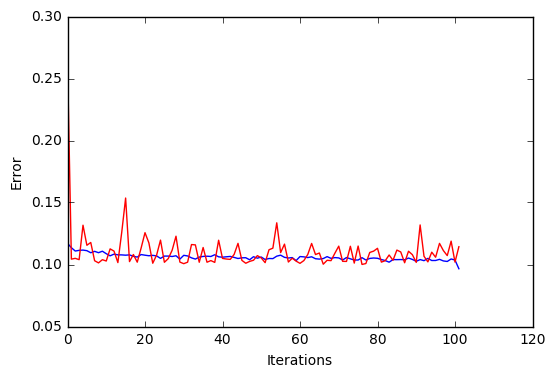

In [12]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

Рассчитаем значение доли неправильных ответов на обучающей и контрольной выборке.

In [13]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1) # Подсчет результата на обучающей выборке
print 'Error on train: ', percentError(res_train, ds_train['target'].argmax(axis=1)), '%' # Подсчет ошибки
res_test = net.activateOnDataset(ds_test).argmax(axis=1) # Подсчет результата на тестовой выборке
print 'Error on test: ', percentError(res_test, ds_test['target'].argmax(axis=1)), '%' # Подсчет ошибки

Error on train:  49.0616621984 %
Error on test:  46.0416666667 %


### Задание. Определение оптимального числа нейронов.
В задании требуется исследовать зависимость ошибки на контрольной выборке в зависимости от числа нейронов в скрытом слое сети. Количество нейронов, по которому предполагается провести перебор, записано в векторе 
```
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
```

1. Для фиксированного разбиения на обучающую и контрольную части подсчитайте долю неправильных ответов (ошибок) классификации на обучении/контроле в зависимости от количества нейронов в скрытом слое сети. Запишите результаты в массивы ```res_train_vec``` и ```res_test_vec```, соответственно. С помощью функции ```plot_classification_error``` постройте график зависимости ошибок на обучении/контроле от количества нейронов. Являются ли графики ошибок возрастающими/убывающими? При каком количестве нейронов достигается минимум ошибок классификации?

2. С помощью функции ```write_answer_nn``` запишите в выходной файл число: количество нейронов в скрытом слое сети, для которого достигается минимум ошибки классификации на контрольной выборке.

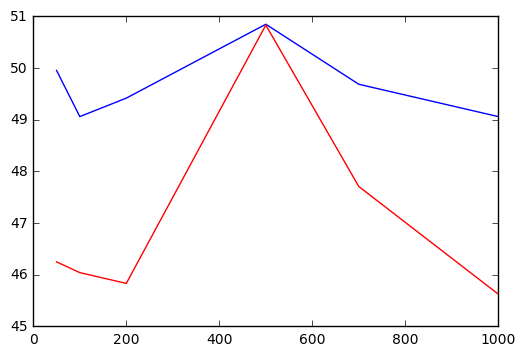

In [22]:
random.seed(0) # Зафиксируем seed для получния воспроизводимого результата
np.random.seed(0)

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
# hidden_neurons_num -- массив размера h, содержащий количество нейронов, по которому предполагается провести перебор,
#   hidden_neurons_num = [50, 100, 200, 500, 700, 1000];
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на обучении;
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на контроле
    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec)
    plt.plot(hidden_neurons_num, res_test_vec, '-r')

def write_answer_nn(optimal_neurons_num):
    with open("nnets_answer1.txt", "w") as fout:
        fout.write(str(optimal_neurons_num))

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
#hidden_neurons_num = [50]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    # Не забудьте про инициализацию весов командой np.random.random((len(net.params)))
    np.random.seed(0)
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(net.params))) 
    net._setParameters(init_params)
    
    random.seed(0)
    trainer = BackpropTrainer(net, dataset=ds_train) 
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
    
    res_train = net.activateOnDataset(ds_train).argmax(axis=1)
    res_test = net.activateOnDataset(ds_test).argmax(axis=1)
    
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1)))
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1)))
    
# Постройте график зависимости ошибок на обучении и контроле в зависимости от количества нейронов
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)          
#  Запишите в файл количество нейронов, при котором достигается минимум ошибки на контроле
write_answer_nn(hidden_neurons_num[res_test_vec.index(min(res_test_vec))]) 

In [23]:

res_test_vec

[46.25,
 46.041666666666664,
 45.833333333333336,
 50.833333333333336,
 47.708333333333336,
 45.625]